# Week 7 Assignment

This week we are collecting some data from Reddit and doing some basic EDA on it. You should:

- create your Reddit account and API keys
- collect data from a subreddit of your choice
    - at a minimum, collect the posts from the subreddit; optionally collect comments on the posts
- save the data to a SQLite3 database
- perform some basic EDA on the data
    - create at least 2 plots
- write a short analysis at the end describing the process and results
- turn in the Jupyter Notebook and PDF printout or export to the week 7 dropbox

***Optional* advanced section**
- Practice SQL queries and select a subsection of the posts you collected
- Modify your code to collect data beyond the 1000 item limit
- Collect comments from the posts for analysis next week and do some EDA on the comments (e.g. who is the top commenter, which commenters have the most up and down votes or most controversial posts, etc)
- examine n-grams ([bigrams](https://stackoverflow.com/a/37651184/4549682), trigrams) or [collocations](https://www.geeksforgeeks.org/nlp-word-collocations/)

Note: There is no solution file for this week.

In [1]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
import credentials #(API key .py)

ModuleNotFoundError: No module named 'praw'

#### 1. Create your Reddit account and API keys

In [2]:
reddit = praw.Reddit(client_id = credentials.client_id,
                    client_secret = credentials.client_secret,
                    user_agent = credentials.user_agent)

In [28]:
#Use list comprehension
reddit_posts_data = {'title': [],
                    'link': [],
                     'created': [],
                    'author': [],
                    'n_comments': [],
                    'score': [],
                    'text': [],
                    'post_id': []}

reddit_comments_data = {'author': [],
                        'score': [],
                        'text': [],
                        'post_id': []}

#### 2. Collect data from a subreddit of your choice

In [29]:
#Pull the top 15 hot posts on the Ethereum subreddit
co_subreddit = reddit.subreddit('ethereum').hot(limit=20)

#Collect subreddit posts
for post in list(co_subreddit):
    reddit_posts_data['title'].append(post.title)
    reddit_posts_data['link'].append(post.permalink)
    reddit_posts_data['created'].append(post.created)
    if post.author is None:
        reddit_posts_data['author'].append(None)
    else:
        reddit_posts_data['author'].append(post.author.name)
    reddit_posts_data['n_comments'].append(post.num_comments)
    reddit_posts_data['score'].append(post.score)
    reddit_posts_data['text'].append(post.selftext)
    reddit_posts_data['post_id'].append(post.id)
    
    #Collect subreddit comments
    post.comments.replace_more(limit=None)
    for comment in post.comments:
        if comment.author is None:
            reddit_comments_data['author'].append('')
        else:
            reddit_comments_data['author'].append(comment.author.name)
        reddit_comments_data['score'].append(comment.score)
        reddit_comments_data['text'].append(comment.body)
        reddit_comments_data['post_id'].append(post.id)

post_df = pd.DataFrame(reddit_posts_data)
comment_df = pd.DataFrame(reddit_comments_data)

In [31]:
#Convert ISO8601 value to datetime type
from datetime import datetime
from datetime import timedelta

post_df.created = pd.to_numeric(post_df.created, errors='coerce')
post_df.created = post_df.created.astype(int)

for index, row in post_df.iterrows():
    iso8601 = datetime.fromtimestamp(row['created'])
    post_df.at[index,'dt_created'] = datetime.strftime(iso8601, "%Y/%m/%d %H:%M:%S")

post_df = post_df.drop('created', axis=1)

In [34]:
#Preview post df
post_df.head()

,title,link,author,n_comments,score,text,post_id,dt_created
0,FreeRossDAO has raised 1000+ ETH. Powerful Eth...,/r/ethereum/comments/r9frxg/freerossdao_has_ra...,sassypersona16,8,122,https://twitter.com/TrashbagsCash/status/14674...,r9frxg,2021/12/05 08:30:59
1,Satoshi owns 5.2% of all the bitcoin supply an...,/r/ethereum/comments/r90qoy/satoshi_owns_52_of...,Historian_investor,414,993,.23% of all ethereum supply,r90qoy,2021/12/04 17:23:57
2,$13 million of stolen ETH is being sold right ...,/r/ethereum/comments/r94obk/13_million_of_stol...,sandygws,68,177,$13 million of stolen ETH being sold live righ...,r94obk,2021/12/04 20:51:12
3,Ethereum showing relative market strength comp...,/r/ethereum/comments/r9bvvb/ethereum_showing_r...,WhalesHeaven,6,40,"This isn't a price discussion post, but rather...",r9bvvb,2021/12/05 04:10:57
4,Ethereum for beginners,/r/ethereum/comments/r9h8ri/ethereum_for_begin...,Artistic_Dwilko,1,10,,r9h8ri,2021/12/05 09:49:44


In [58]:
comment_df.head()

,author,score,text,post_id
0,Sutied,2,If I only had 100 ETH to donate lmao,r9frxg
1,ProfessorCrumbledore,2,Could have almost bought a pardon a year ago w...,r9frxg
2,DonLemonAIDS,2,Of all the valid objects of sympathy out there...,r9frxg
3,atxdevdude,57,I mean clearly Vitalik would make less of an i...,r90qoy
4,hesiod2,44,For context: Jeff Bezos owns 10% of Amazon. Z...,r90qoy


#### 3. Save the data to a SQLite3 database

In [36]:
import sqlite3
con = sqlite3.connect('Week7_co_reddit.sqlite')
post_df.to_sql('posts', con, if_exists='replace')
comment_df.to_sql('comments', con, if_exists='replace')
con.close()

In [40]:
#Preview SQL with query
test_con = sqlite3.connect('Week7_co_reddit.sqlite')
test_df = pd.read_sql_query('SELECT title, n_comments FROM posts;', test_con)
test_con.close()
test_df

,title,n_comments
0,FreeRossDAO has raised 1000+ ETH. Powerful Eth...,8
1,Satoshi owns 5.2% of all the bitcoin supply an...,414
2,$13 million of stolen ETH is being sold right ...,68
3,Ethereum showing relative market strength comp...,6
4,Ethereum for beginners,1
5,I bought 1.1 ETH on Nov 10th for $5000. I am s...,38
6,Updated and detailed roadmap for the Ethereum ...,2
7,Why is Foundation.app running on my phone even...,5
8,Illuminating the Dark Forest,6
9,The Ethereum Data Service - a gas-efficient so...,0


#### 4. Perform some basic EDA on the data

<AxesSubplot:xlabel='score', ylabel='n_comments'>

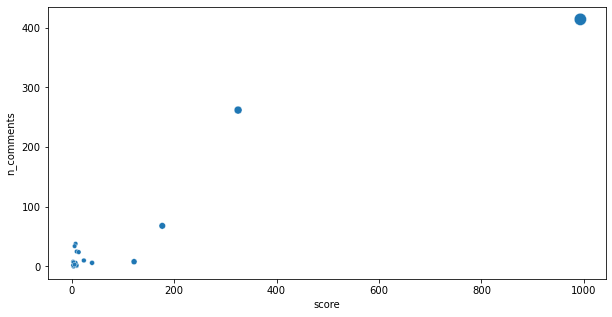

In [76]:
#View relationship between number of comments and score
import seaborn as sns
plt.figure(figsize=(10,5))
sns.scatterplot(data=post_df, x="score", y="n_comments", size="score", legend=False, sizes=(20, 150))

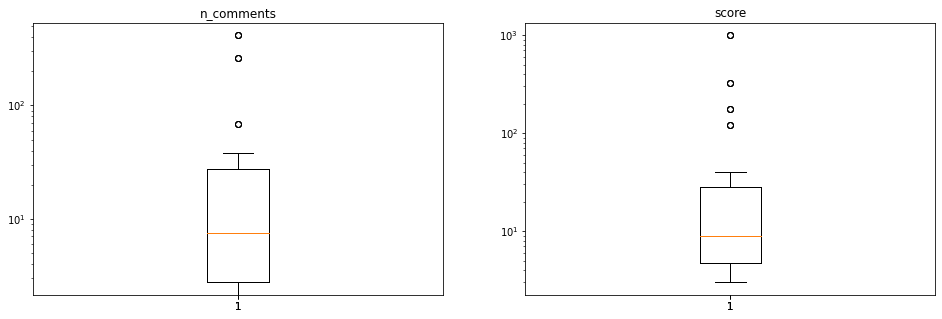

In [56]:
#View comment & score outliers
plt.figure(figsize=(25, 5))
cnt = 1
outlier_col = ['n_comments','score']
for x in outlier_col:
    plt.subplot(1,3, cnt)
    plt1 = plt.boxplot(post_df[x])
    plt2 = plt.boxplot(post_df[x])
    plt3 = plt.boxplot(post_df[x])
    plt.title(x)
    cnt = cnt + 1
    plt.yscale('log')

# Analysis

This assignment was well designed, and I did not have any issues collecting the data. The data I collected was from the subreddit Ethereum. Ethereum is the second-largest cryptocurrency by market capitalization. The conversations within this community can be pretty polarizing, so I'm looking forward to next week's assignment. I limited the number of posts gathered to 20 since anymore had a heavy hit on performance. I also collected the comments for each post as they will provide greater insight into what is being discussed within this subreddit. 